### Libraries

In [50]:
#Data Manipulation
import pandas as pd
import numpy as np
#Plots
import matplotlib.pyplot as plt
import plotly.graph_objects as go
plt.style.use('seaborn-v0_8-darkgrid')

#Utilities
import warnings
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils import shuffle
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
import itertools
import time

#ML Models
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX

#Tensorflow
import tensorflow as tf
from keras.layers import LSTM, Dense, InputLayer
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.losses import MeanAbsoluteError
from keras.optimizers import Adam
from keras.metrics import RootMeanSquaredError


warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
parameters = {
    "dataset":{
        "path": "../data/data_casal_montserratina/LaMonserratina_CLEAN.csv",
        "trainingSize": .60,
        "validationSize": .20,
        "testSize": .20
    },
    "validation": {
        "n_splits" : 6
    },
    "lstm":{
        "epochs": 200,
        "batch_size": 64,
        "lr": 0.00001
    }
}

In [51]:
def plotDatasetSplit(X_train_dates, X_val_dates, X_test_dates, y_train, y_val, y_test):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=X_train_dates, y=y_train, mode="lines", name="Train"))
    fig.add_trace(go.Scatter(x=X_val_dates, y=y_val, mode="lines", name="Validation"))
    fig.add_trace(go.Scatter(x=X_test_dates, y=y_test, mode="lines", name="Test"))
    fig.update_layout(
        title = "Dataset Partition",
        xaxis_title = "Date",
        yaxis_title ="Consumption [kWh]",
        width = 1000,
        height = 400,
        margin = dict(l=30, r=20, t=35, b=60),
        legend = dict(
            orientation = "h",
            yanchor = "bottom",
            y = 1.05,
            xanchor = "right",
            x=1
        )
    )
    fig.write_image("../results/dataset_split.png", width=1000, scale=2, format="png")
    fig.show()

In [52]:
def plotPredictions(dates, y_pred, y_test, filename=None):
    fig = go.Figure()
    trace1 = go.Scatter(x=dates, y=y_test, name="test", mode="lines")
    trace2 = go.Scatter(x=dates, y=y_pred, name="predictions", mode="lines")
    fig.add_trace(trace1)
    fig.add_trace(trace2)
    fig.update_layout(
        title="Real value vs Predicted in Test Data",
        xaxis_title="Date Time",
        yaxis_title="Consumption [kWh]",
        width=1020,
        height=450,
        margin = dict(l=70, r=20, t=55, b=20),
        legend = dict(
            orientation = "h",
            yanchor="top",
            y=1.1,
            xanchor="left",
            x=0.76
        )
    )
    if filename is not None:
        fig.write_image(f"../results/{filename}.png", format="png", scale=2, width=1000)
    fig.show()

In [128]:
def permutation_feature_importance(model, X_test, y_test, feature_names):
    y_pred = model.predict(X_test)

    mae_ref = mean_absolute_error(np.exp(y_test), np.exp(y_pred))

    feature_importance = np.zeros(X_test.shape[1])

    for i in tqdm(range(X_test.shape[1]), total=(X_test.shape[1])):
        #Make a Copy of the Test Subset and Permute its values
        X_test_permuted = X_test.copy()
        X_test_permuted[:, i] = shuffle(X_test_permuted[:, i])

        #Calculate the metrics
        y_pred_permuted = model.predict(X_test_permuted)
        mae_permuted = mean_absolute_error(np.exp(y_test), np.exp(y_pred_permuted))

        #Calculate the difference in the metrics
        feature_importance[i] = mae_ref - mae_permuted
    
    #Normalize feature importances
    feature_importance /= feature_importance.sum()

    #Sort indexes
    sorted_indexes = feature_importance.argsort()[::-1]
    sorted_importances = feature_importance[sorted_indexes]
    sorted_importances_names = feature_names[sorted_indexes]

    #Bar Plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
    plt.yticks(range(len(sorted_importances)), sorted_importances_names)
    plt.xlabel('Relative Importance')
    plt.ylabel('Features')
    plt.title('Permutation Feature Importance')
    plt.savefig('../results/PermutationFeatureImportance.png', bbox_inches='tight', dpi=300)
    plt.show()

In [54]:
def calculate_metrics(y_true, y_pred): 
    epsilon = 1e-10   
    # MAE (Mean Absolute Error)
    mae = mean_absolute_error(y_true, y_pred)
    # RMSE (Root Mean Squared Error)
    rmse = root_mean_squared_error(y_true, y_pred)
    # MdAPE (Median Absolute Percentage Error)
    mdape = np.median(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), epsilon, None))) * 100
    # MAAPE (Mean ArcTangent Percentage Error)
    maape = np.mean(np.arctan(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), epsilon, None)))) * 100

    return mae, rmse, mdape, maape

def median_absolute_percentage_error(y_true, y_pred):
    epsilon = np.finfo(float).eps
    y_true_clipped = np.clip(np.abs(y_true), epsilon, None)

    percentage_errors = np.abs((y_true - y_pred) / y_true_clipped) * 100

    mdape_value = np.median(percentage_errors)
    
    return mdape_value

def plot_metrics(train_data, validation_data, train_names, val_names, yaxis_title, parameters):
    epochs_list = np.arange(0, parameters["lstm"]["epochs"])
    fig = go.Figure()
    for train, name in zip(train_data, train_names):
        trace = go.Scatter(x = epochs_list, y=train, name=name, mode="lines")
        fig.add_trace(trace)

    if validation_data is not None:
        for validation, name in zip(validation_data, val_names):
            trace = go.Scatter(x = epochs_list, y=validation, name=name, mode="lines")
            fig.add_trace(trace)

    fig.update_layout(
        title = "Metrics in Training/Validation",
        xaxis_title = "Epoch",
        yaxis_title = yaxis_title,
        width = 800,
        height = 400,
        margin = dict(l=40, r=30, t=50, b=30),
        legend = dict(
            orientation = "h",
            yanchor = "top",
            y = .98,
            xanchor = "right",
            x = .98
        ) 
    )
    fig.show()

In [55]:
def plotLosses(train_loss, validation_loss, parameters):
    epochs_list = np.arange(0, int(parameters["lstm"]["epochs"]))
    fig = go.Figure()
    trace1 = go.Scatter(x=epochs_list, y=train_loss, name="Training Loss", mode="lines")
    fig.add_trace(trace1)
    if validation_loss is not None:
        trace2 = go.Scatter(x=epochs_list, y=validation_loss, name="Validation Loss", mode="lines")
        fig.add_trace(trace2)
    fig.update_layout(
        title = "Training and Validation Losses",
        xaxis_title = "Epoch",
        yaxis_title = "MSE Loss Value",
        width = 800,
        height = 400,
        margin = dict(l=40, r=30, t=50, b=30),
        legend = dict(
            orientation = "h",
            yanchor = "top",
            y = .98,
            xanchor = "right",
            x = .98
        ) 
    )
    fig.show()

In [77]:
#Create LSTM Model
from keras import ops
def create_LSTM_Model(num_features, n_units, n_layers, dropout):
    model = Sequential()
    model.add(InputLayer((num_features, 1)))
    for _ in range(n_layers - 1):
        model.add(LSTM(units=n_units, activation='tanh',kernel_initializer='glorot_normal', return_sequences=True, dropout=dropout))
    model.add(LSTM(units=n_units, activation='relu', kernel_initializer='glorot_normal'))
    model.add(Dense(80, activation='linear'))
    model.add(Dense(1, activation='linear'))
    return model

def maape_fn(y_true, y_pred):
    epsilon = tf.keras.backend.epsilon()
    y_true_abs = tf.abs(y_true)
    
    y_true_clipped = tf.clip_by_value(y_true_abs, epsilon, float('inf'))
    
    percentage_errors = tf.abs((y_true - y_pred) / y_true_clipped)
    maape = tf.reduce_mean(tf.atan(percentage_errors)) * 100
    
    return maape

def mdape_fn(y_true, y_pred):
    epsilon = tf.keras.backend.epsilon()
    y_true_abs = tf.abs(y_true)
    
    y_true_clipped = tf.clip_by_value(y_true_abs, epsilon, float('inf'))
    
    percentage_errors = tf.abs((y_true - y_pred) / y_true_clipped)
    mdape = ops.median(percentage_errors) * 100
    
    return mdape

def train_model(model, X, y, parameters, validation_data=None, verbose=False):
    if not isinstance(X, np.ndarray):
        X = X.to_numpy()
    if not isinstance(y, np.ndarray):
        y = y.to_numpy()
    X = X.reshape((X.shape[0], X.shape[1], 1))
    y = y.reshape((y.shape[0], 1))

    
    model.compile(
        loss = "mse", 
        optimizer=Adam(learning_rate=parameters["lstm"]["lr"]), 
        metrics=[
            MeanAbsoluteError(),
            RootMeanSquaredError(),
            mdape_fn,
            maape_fn
        ]
    )
    if validation_data is not None:
        early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
        return model.fit(
            X, 
            y, 
            epochs=parameters["lstm"]["epochs"],
            batch_size = parameters["lstm"]["batch_size"],
            validation_data = (validation_data[0], validation_data[1]),
            verbose=verbose, 
            callbacks=[early_stopping]
        )
    else:
        early_stopping = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
        return model.fit(
            X,
            y,
            epochs=parameters["lstm"]["epochs"],
            batch_size = parameters["lstm"]["batch_size"],
            verbose=verbose,
            callbacks=[early_stopping]
        )

In [57]:
def addNLags(df, lags_list):
    lag_df = df.copy()
    for lag in lags_list:
        lag_df[f'lag_{lag}'] = lag_df["Consumo"].shift(lag * 24)

    return lag_df.fillna(0)

def parseData(df):
    for col in df:
        if col != "Date":
            df[col] = df[col].astype(float)
    return df

### Split Dataset

In [113]:
df = pd.read_csv(parameters["dataset"]["path"], index_col=None)
df["Date"] = pd.to_datetime(df["Date"])
dates = df["Date"]

df = df.drop(columns=["Date"], axis=1)
df = parseData(df)
df.columns = df.columns.map(str)

y = df["Consumo"]

X = df.drop(columns=["Consumo", "pressure_msl_hPa", "dew_point_2m_C", "surface_pressure_hPa",
    "cloud_cover_%", "cloud_cover_high_%", "et0_fao_evapotranspiration_mm", "vapour_pressure_deficit_kPa",
    "wind_speed_10m_km/h", "wind_direction_10m_º", "wind_gusts_10m", "terrestrial_radiation_W/m2",
    "DayOfYear", "DayOfWeek", "temp_cluster", "Season", "Month", "relative_humidity_2m_%", "Month_sin", "is_day", "DayOfYear_sin", "sunshine_duration_sec",
    "direct_radiation_W/m2", "global_tilted_irradiance_W/m2", "DayOfYear_cos", "DayOfWeek_cos", "apparent_temperature_C", "Temp_interna_Modulo_C", "Year"], axis=1)

col_names = list(X.columns)

trainingSize = int(parameters["dataset"]["trainingSize"] * df.shape[0])
validationSize = trainingSize + int(parameters["dataset"]["validationSize"] * df.shape[0])

X_train, y_train = X.loc[:trainingSize, :].copy(), y.loc[:trainingSize].copy()
X_val, y_val = X.loc[trainingSize:validationSize, :].copy(), y.loc[trainingSize:validationSize].copy()
X_test, y_test = X.loc[validationSize:, :].copy(), y.loc[validationSize:].copy()

X_train_dates = dates.loc[:trainingSize].copy()
X_val_dates = dates.loc[trainingSize:validationSize].copy()
X_test_dates = dates.loc[validationSize:].copy()
print(f"Total Lags: {len(df)}")
print(f"Training Size:{len(X_train)}")
print(f"Validation Size:{len(X_val)}")
print(f"Test Size: {len(X_test)}")
X.columns

Total Lags: 12046
Training Size:7228
Validation Size:2410
Test Size: 2410


Index(['temperature_2m_C', 'shortwave_radiation_W/m2',
       'diffuse_radiation_W/m2', 'direct_normal_irradiance_W/m2', 'Hour',
       'isWeekend', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'Month_cos',
       'isHoliday'],
      dtype='object')

In [59]:
plotDatasetSplit(X_train_dates, X_val_dates, X_test_dates, y_train, y_val, y_test)

## Possible Models

### SARIMAX

In [60]:
df_sarimax = pd.read_csv(parameters["dataset"]["path"], index_col=None)
df_sarimax["Date"] = pd.to_datetime(df_sarimax["Date"])
df_sarimax = parseData(df_sarimax)
train = df_sarimax.loc[:validationSize].copy()
test = df_sarimax.loc[validationSize:].copy()
model = SARIMAX(train['Consumo'], exog=train[col_names], order=(2, 0, 1), seasonal_order=(2, 0, 1, 24))
model_fit = model.fit(disp=False)
exog_future = test[col_names]
forecast = model_fit.get_forecast(steps=len(test), exog=exog_future)
forecast_mean = forecast.predicted_mean   

In [61]:
mae, rmse, mdape, maape = calculate_metrics(test["Consumo"].values, forecast_mean.values)
print(f"MAE: {mae}, RMSE: {rmse}, MAAPE: {maape}, MdAPE: {mdape}")
plotPredictions(test["Date"], forecast_mean, test["Consumo"])

MAE: 2.6928505365287454, RMSE: 4.019847372757255, MAAPE: 68.336437353893, MdAPE: 60.3807052651527


In [62]:
plotPredictions(X_test_dates[:30*24], forecast_mean.values[:30*24], y_test.values[:30*24])

### KNN

In [63]:
knn = KNeighborsRegressor(n_neighbors=20, weights='distance')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
mae, rmse, mdape, maape = calculate_metrics(y_test, y_pred)
print(f"MAE: {mae}, RMSE: {rmse}, MAAPE: {maape}, MdAPE: {mdape}")

MAE: 2.3083101198770968, RMSE: 3.78119882605459, MAAPE: 61.59298158963517, MdAPE: 46.010853348529636


In [64]:
plotPredictions(X_test_dates, y_pred, y_test)

In [65]:
plotPredictions(X_test_dates[:30*24], y_pred[:30*24], y_test[:30*24])

In [66]:
plotPredictions(X_test_dates[:7*24], y_pred[:7*24], y_test[:7*24])

### LightGBM

In [67]:
lgbm = LGBMRegressor(objective="regression", boosting_type='gbdt', n_estimators=1000, learning_rate=0.01, random_state=123, n_jobs=-1, early_stopping_rounds=100, verbose=100)
lgbm.fit(X_train, y_train, eval_metric="mae", eval_set=[(X_val, y_val)])
y_pred = lgbm.predict(X_test, num_iteration=lgbm.best_iteration_)
mae, rmse, mdape, maape = calculate_metrics(y_test, y_pred)
print(f"MAE: {mae}, RMSE: {rmse}, MAAPE: {maape}, MdAPE: {mdape}")

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.259519
[LightGBM] [Debug] init for col-wise cost 0.000214 seconds, init for row-wise cost 0.000749 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 1088
[LightGBM] [Info] Number of data points in the train set: 7228, number of used features: 11
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Start training from score 4.195766
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
Training until validation scores 

In [68]:
plotPredictions(X_test_dates, y_pred, y_test)

In [69]:
plotPredictions(X_test_dates[:30*24], y_pred[:30*24], y_test[:30*24])

### XGBoost

In [70]:
xgboost = XGBRegressor(n_estimators=1000, random_state=123, learning_rate=0.03, max_depth=7, verbose=0)
xgboost.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
           eval_metric='mae', 
           early_stopping_rounds=100)
y_pred = xgboost.predict(X_test)
mae, rmse, mdape, maape = calculate_metrics(y_test, y_pred)
print(f"MAE: {mae}, RMSE: {rmse}, MAAPE: {maape}, MdAPE: {mdape}")

[0]	validation_0-mae:4.46238
[1]	validation_0-mae:4.42860
[2]	validation_0-mae:4.39554
[3]	validation_0-mae:4.36578
[4]	validation_0-mae:4.33804
[5]	validation_0-mae:4.30804
[6]	validation_0-mae:4.28175
[7]	validation_0-mae:4.25453
[8]	validation_0-mae:4.22666
[9]	validation_0-mae:4.20424
[10]	validation_0-mae:4.17872
[11]	validation_0-mae:4.15762
[12]	validation_0-mae:4.13285
[13]	validation_0-mae:4.11085
[14]	validation_0-mae:4.09000
[15]	validation_0-mae:4.07195
[16]	validation_0-mae:4.05441
[17]	validation_0-mae:4.03837
[18]	validation_0-mae:4.02059
[19]	validation_0-mae:4.00237
[20]	validation_0-mae:3.98578
[21]	validation_0-mae:3.96998
[22]	validation_0-mae:3.95570
[23]	validation_0-mae:3.94026
[24]	validation_0-mae:3.92695
[25]	validation_0-mae:3.91545
[26]	validation_0-mae:3.90108
[27]	validation_0-mae:3.88744
[28]	validation_0-mae:3.87495
[29]	validation_0-mae:3.86259
[30]	validation_0-mae:3.85053
[31]	validation_0-mae:3.84124
[32]	validation_0-mae:3.83203
[33]	validation_0-ma

In [71]:
plotPredictions(X_test_dates, y_pred, y_test)

In [72]:
plotPredictions(X_test_dates[:30*24], y_pred[:30*24], y_test[:30*24])

### Long Short-Term Memory (LSTM) with Validation Set

In [73]:
lstm = create_LSTM_Model(
    num_features = X_train.shape[1], 
    n_units = 64, 
    n_layers = 2, 
    dropout = 0.2) 
lstm.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 11, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 80)             │         5,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,201 (215.63 KB)

 Trainable params: 55,201 (215.63 KB)

 Non-trainable params: 0 (0.00 B)

In [78]:
train_history = train_model(
    model = lstm, 
    X = X_train, 
    y = y_train, 
    parameters = parameters,
    validation_data = (X_val, y_val),
    verbose = True)

y_pred = lstm.predict(
    x = X_test,
    batch_size = parameters["lstm"]["batch_size"]
).flatten()
mae, rmse, mdape, maape = calculate_metrics(y_test, y_pred)
print(f"MAE: {mae}, RMSE: {rmse}, MAAPE: {maape}, MdAPE: {mdape}")

Epoch 1/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 48.1862 - maape_fn: 89.9714 - mdape_fn: 98.1040 - mean_absolute_error: 4.1715 - root_mean_squared_error: 6.9336 - val_loss: 83.3812 - val_maape_fn: 88.7990 - val_mdape_fn: 94.6085 - val_mean_absolute_error: 4.9531 - val_root_mean_squared_error: 9.1313
Epoch 2/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 45.4767 - maape_fn: 87.3866 - mdape_fn: 94.8301 - mean_absolute_error: 4.0654 - root_mean_squared_error: 6.7397 - val_loss: 81.1978 - val_maape_fn: 85.0614 - val_mdape_fn: 89.7368 - val_mean_absolute_error: 4.8259 - val_root_mean_squared_error: 9.0110
Epoch 3/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 43.1787 - maape_fn: 84.1395 - mdape_fn: 91.0277 - mean_absolute_error: 3.9238 - root_mean_squared_error: 6.5695 - val_loss: 78.1061 - val_maape_fn: 78.6221 - val_mdape_fn: 82.4753 - val_mean_absolute_error: 4.6338 - val_root_mean_squared_error: 8.8378
Epoch 4/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - lo

In [79]:
plotPredictions(X_test_dates, y_pred, y_test)

In [80]:
plotLosses(train_history.history["loss"], train_history.history["val_loss"], parameters)

In [81]:
# MAE and RMSE
plot_metrics(
    train_data = [train_history.history["root_mean_squared_error"], train_history.history["mean_absolute_error"]], 
    validation_data = [train_history.history["val_root_mean_squared_error"], train_history.history["val_mean_absolute_error"]], 
    train_names = ["Training RMSE", "Training MAE"],
    val_names = ["Validation RMSE", "Validation MAE"],
    yaxis_title = "RMSE / MAE",
    parameters = parameters
)

In [82]:
# MAPE and MdAPE
plot_metrics(
    train_data = [train_history.history["maape_fn"], train_history.history["mdape_fn"]], 
    validation_data = [train_history.history["val_maape_fn"], train_history.history["val_mdape_fn"]], 
    train_names = ["Training MAAPE", "Training MdAPE"],
    val_names = ["Validation MAAPE", "Validation MdAPE"],
    yaxis_title = "MAAPE / MdAPE",
    parameters = parameters
)

### LSTM without Validation Set

In [83]:
lstm = create_LSTM_Model(
    num_features = X_train.shape[1], 
    n_units = 64, 
    n_layers = 2, 
    dropout = 0.2) 
lstm.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 11, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 80)             │         5,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,201 (215.63 KB)

 Trainable params: 55,201 (215.63 KB)

 Non-trainable params: 0 (0.00 B)

In [84]:
train_history = train_model(
    model = lstm, 
    X = np.concatenate([X_train, X_val], axis=0), 
    y = np.concatenate([y_train, y_val], axis=0),
    parameters = parameters,
    validation_data=None,
    verbose = True)

y_pred = lstm.predict(
    x = X_test,
    batch_size = parameters["lstm"]["batch_size"]
).flatten()
mae, rmse, mdape, maape = calculate_metrics(y_test, y_pred)
print(f"MAE: {mae}, RMSE: {rmse}, MAAPE: {maape}, MdAPE: {mdape}")

Epoch 1/200
151/151 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 54.1131 - maape_fn: 90.4969 - mdape_fn: 98.6391 - mean_absolute_error: 4.3187 - root_mean_squared_error: 7.3526
Epoch 2/200
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 55.3679 - maape_fn: 87.4627 - mdape_fn: 94.7835 - mean_absolute_error: 4.2835 - root_mean_squared_error: 7.4402
Epoch 3/200
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 50.2884 - maape_fn: 81.2370 - mdape_fn: 87.9736 - mean_absolute_error: 4.0007 - root_mean_squared_error: 7.0882
Epoch 4/200
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 47.1422 - maape_fn: 73.8513 - mdape_fn: 78.4140 - mean_absolute_error: 3.7487 - root_mean_squared_error: 6.8549
Epoch 5/200
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 45.5891 - maape_fn: 70.1144 - mdape_fn: 75.5986 - mean_absolute_error: 3.7626 - root_mean_squared_error: 6.7416
Epoch 6/200
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 43.6601 - maape_fn: 72.0266 - mdape_fn: 76.2297 - mean_absolute_erro

In [85]:
plotPredictions(X_test_dates, y_pred, y_test)

In [86]:
plotPredictions(X_test_dates[:30*24], y_pred[:30*24], y_test[:30*24])

In [87]:
plotLosses(train_history.history["loss"], None, parameters)

In [88]:
# MAE and RMSE
plot_metrics(
    train_data = [train_history.history["root_mean_squared_error"], train_history.history["mean_absolute_error"]], 
    validation_data = None, 
    train_names = ["Training RMSE", "Training MAE"],
    val_names = None,
    yaxis_title = "RMSE / MAE",
    parameters = parameters
)

In [89]:
# MAPE and MdAPE
plot_metrics(
    train_data = [train_history.history["maape_fn"], train_history.history["mdape_fn"]], 
    validation_data = None, 
    train_names = ["Training MAAPE", "Training MdAPE"],
    val_names = None,
    yaxis_title = "MAAPE / MdAPE",
    parameters = parameters
)

### Lags as Predictors

In [120]:
def gridSearchLags(df, lags_combinations, trainingSize):
    y = df["Consumo"]
    X = df.drop(columns=["Consumo", "pressure_msl_hPa", "dew_point_2m_C", "surface_pressure_hPa",
        "cloud_cover_%", "cloud_cover_high_%", "et0_fao_evapotranspiration_mm", "vapour_pressure_deficit_kPa",
        "wind_speed_10m_km/h", "wind_direction_10m_º", "wind_gusts_10m", "terrestrial_radiation_W/m2",
        "DayOfYear", "DayOfWeek", "temp_cluster", "Season", "Month", "relative_humidity_2m_%", "Month_sin", "is_day", "DayOfYear_sin", "sunshine_duration_sec",
        "direct_radiation_W/m2", "global_tilted_irradiance_W/m2", "DayOfYear_cos", "DayOfWeek_cos", "apparent_temperature_C", "Temp_interna_Modulo_C", "Year"], axis=1)    
    X_train, y_train = X.iloc[:trainingSize, :].copy(deep=True), y.iloc[:trainingSize].copy(deep=True)
    X_test, y_test = X.iloc[trainingSize:, :].copy(deep=True), y.iloc[trainingSize:].copy(deep=True)
    results = pd.DataFrame(columns=["Lags", "MAE_Test", "RMSE_Test", "MAAPE_Test", "MdAPE_Test"])
    model = XGBRegressor(n_estimators=1300, random_state=123, learning_rate=0.01, max_depth=5, verbose=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae, rmse, mdape, maape = calculate_metrics(y_test, y_pred)
    results.loc[len(results.index)] = [[0], mae, rmse, maape, mdape]

    for lags in tqdm(lags_combinations, total=len(lags_combinations)):
        df_copy = df.copy(deep=True)
        df_copy = addNLags(df_copy, lags)
        y = df_copy["Consumo"]
        X = df_copy.drop(columns=["Consumo", "pressure_msl_hPa", "dew_point_2m_C", "surface_pressure_hPa",
            "cloud_cover_%", "cloud_cover_high_%", "et0_fao_evapotranspiration_mm", "vapour_pressure_deficit_kPa",
            "wind_speed_10m_km/h", "wind_direction_10m_º", "wind_gusts_10m", "terrestrial_radiation_W/m2",
            "DayOfYear", "DayOfWeek", "temp_cluster", "Season", "Month", "relative_humidity_2m_%", "Month_sin", "is_day", "DayOfYear_sin", "sunshine_duration_sec",
            "direct_radiation_W/m2", "global_tilted_irradiance_W/m2", "DayOfYear_cos", "DayOfWeek_cos", "apparent_temperature_C", "Temp_interna_Modulo_C", "Year"], axis=1)
        X_train, y_train = X.loc[:trainingSize, :].copy(deep=True), y.loc[:trainingSize].copy(deep=True)
        X_test, y_test = X.loc[trainingSize:, :].copy(deep=True), y.loc[trainingSize:].copy(deep=True)
        model = XGBRegressor(n_estimators=1300, random_state=123, learning_rate=0.01, max_depth=7, verbose=0)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae, rmse, mdape, maape = calculate_metrics(y_test, y_pred)
        results.loc[len(results.index)] = [lags, mae, rmse, maape, mdape]

    best_mae_index = results["MAE_Test"].idxmin()
    best_rmse_index = results["RMSE_Test"].idxmin()
    best_maape_index = results["MAAPE_Test"].idxmin()
    best_mdape_index = results["MdAPE_Test"].idxmin()
    best_mae_lags = results.loc[best_mae_index, "Lags"]
    best_rmse_lags = results.loc[best_rmse_index, "Lags"]
    best_mape_lags = results.loc[best_maape_index, "Lags"]
    best_mdape_lags = results.loc[best_mdape_index, "Lags"]
    print(f"Mejor combinación de lags basada en MAE: {best_mae_lags} con MAE: {results.loc[best_mae_index, 'MAE_Test']}")
    print(f"Mejor combinación de lags basada en RMSE: {best_rmse_lags} con RMSE: {results.loc[best_rmse_index, 'RMSE_Test']}")
    print(f"Mejor combinación de lags basada en MAAPE: {best_mape_lags} con MAAPE: {results.loc[best_maape_index, 'MAAPE_Test']}")
    print(f"Mejor combinación de lags basada en MdAPE: {best_mdape_lags} con MdAPE: {results.loc[best_mdape_index, 'MdAPE_Test']}")

    return results, best_mae_lags

In [124]:
lags_combinations = []
possible_lags = [1, 2, 3, 4, 5, 6, 7, 14]

for i in range(1, len(possible_lags) + 1):
    lags_combinations.extend(itertools.combinations(possible_lags, i))
lags_combinations = [list(combo) for combo in lags_combinations]

In [125]:
results, best_lags_comb = gridSearchLags(df.copy(deep=True), lags_combinations, validationSize)
results = results.to_markdown(index=False)
print(results)

100%|██████████| 255/255 [16:22<00:00,  3.85s/it]

Mejor combinación de lags basada en MAE: [1, 6] con MAE: 1.5631650170719027
Mejor combinación de lags basada en RMSE: [1, 6] con RMSE: 2.8601947683532774
Mejor combinación de lags basada en MAAPE: [2, 5, 6, 7, 14] con MAAPE: 52.86597480648708
Mejor combinación de lags basada en MdAPE: [3, 4, 5, 6, 7, 14] con MdAPE: 27.09159255027771
| Lags                      |   MAE_Test |   RMSE_Test |   MAAPE_Test |   MdAPE_Test |
|:--------------------------|-----------:|------------:|-------------:|-------------:|
| [0]                       |    1.74129 |     3.13261 |      55.2608 |      34.243  |
| [1]                       |    1.66339 |     3.01302 |      54.5058 |      31.003  |
| [2]                       |    1.72155 |     3.18531 |      54.6483 |      31.0942 |
| [3]                       |    1.7196  |     3.13518 |      54.6097 |      32.2521 |
| [4]                       |    1.72363 |     3.16444 |      54.9327 |      33.3286 |
| [5]                       |    1.77056 |     3.28643 |

In [126]:
best_lags_comb

[1, 6]

In [93]:
df = pd.read_csv(parameters["dataset"]["path"], index_col=None)
df["Date"] = pd.to_datetime(df["Date"])
dates = df["Date"]
dates = pd.to_datetime(dates)
df = addNLags(df, [1, 2, 3, 4, 5, 6, 7, 14])
df = df.drop(columns=["Date"], axis=1)
df = parseData(df)
df.columns = df.columns.map(str)
y = df["Consumo"]
X = df.drop(columns=["Consumo", "pressure_msl_hPa", "dew_point_2m_C", "surface_pressure_hPa",
    "cloud_cover_%", "cloud_cover_high_%", "et0_fao_evapotranspiration_mm", "vapour_pressure_deficit_kPa",
    "wind_speed_10m_km/h", "wind_direction_10m_º", "wind_gusts_10m", "terrestrial_radiation_W/m2",
    "DayOfYear", "DayOfWeek", "temp_cluster", "Season", "Month", "relative_humidity_2m_%", "Month_sin", "is_day", "DayOfYear_sin", "sunshine_duration_sec",
    "direct_radiation_W/m2", "global_tilted_irradiance_W/m2", "DayOfYear_cos", "DayOfWeek_cos", "apparent_temperature_C", "Temp_interna_Modulo_C", "Year"], axis=1)
col_names = list(X.columns)

validationSize = int(parameters["dataset"]["trainingSize"] * df.shape[0]) + int(parameters["dataset"]["validationSize"] * df.shape[0])

X_train, y_train = X.loc[:validationSize, :].copy(), y.loc[:validationSize].copy()
X_test, y_test = X.loc[validationSize:, :].copy(), y.loc[validationSize:].copy()

X_train_dates = dates.loc[:validationSize].copy()
X_test_dates = dates.loc[validationSize:].copy()
print(f"Total Lags: {len(df)}")
print(f"Training Size:{len(X_train)}")
print(f"Test Size: {len(X_test)}")
X.columns

Total Lags: 12046
Training Size:9637
Test Size: 2410


Index(['temperature_2m_C', 'shortwave_radiation_W/m2',
       'diffuse_radiation_W/m2', 'direct_normal_irradiance_W/m2', 'Hour',
       'isWeekend', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'Month_cos',
       'isHoliday', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6',
       'lag_7', 'lag_14'],
      dtype='object')

### List of Models to Test

In [109]:
models, models_names = [], []
#SARIMAX Model
sarimax_col_names = [col for col in col_names if "lag" not in col]
SARIMAX_model = SARIMAX(y_train, exog=X_train[sarimax_col_names], order=(2, 0, 1), seasonal_order=(2, 0, 1, 24))
models.append(SARIMAX_model)
models_names.append('SARIMAX')

#K-NN Model
model_knn = KNeighborsRegressor(n_neighbors=15, weights='uniform')
models.append(model_knn)
models_names.append("KNNr_15")

#Tree Models
model_LGBM = LGBMRegressor(boosting_type='gbdt', n_estimators=1000, learning_rate=0.01, random_state=123, n_jobs=-1, verbose=0)
model_XGB = XGBRegressor(n_estimators=1000, random_state=123, learning_rate=0.01, max_depth=5, verbose=0)
models.append(model_LGBM)
models_names.append("LGBM_1000")
models.append(model_XGB)
models_names.append("XGB_1000")

#LSTM Model
model_lstm = create_LSTM_Model(X_train.shape[1], 64, 1, 0.2)
models.append(model_lstm)
models_names.append("LSTM")

['temperature_2m_C', 'shortwave_radiation_W/m2', 'diffuse_radiation_W/m2', 'direct_normal_irradiance_W/m2', 'Hour', 'isWeekend', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'Month_cos', 'isHoliday']


### Benchmark Transformations

In [96]:
def benchmarkTransformations(models, models_names, X, y, trainingSize):
    results = pd.DataFrame(columns=["Model", "RMSE", "MAE", "MAAPE", "MdAPE","RMSE Log", "MAE Log", "MAAPE Log", "MdAPE Log", "RMSE SQRT", "MAE SQRT", "MAAPE SQRT", "MdAPE SQRT"])
    for model, model_name in tqdm(zip(models, models_names), total=len(models)):
        X_train, y_train = X.iloc[:trainingSize, :].copy(deep=True), y.iloc[:trainingSize].copy(deep=True)
        X_test, y_test = X.iloc[trainingSize:, :].copy(deep=True), y.iloc[trainingSize:].copy(deep=True)
        # No transformation
        if "LSTM" in model_name:
            train_model(model, X_train, y_train, parameters)
            y_pred = model.predict(
                x = X_test,
                batch_size = parameters["lstm"]["batch_size"]
            ).flatten()
            mae, rmse, mdape, maape = calculate_metrics(y_test, y_pred)
        elif "SARIMAX" in model_name:
            SARIMAX_model = SARIMAX(y_train, exog=X_train[sarimax_col_names], order=(2, 0, 1), seasonal_order=(2, 0, 1, 24))
            model_fit = SARIMAX_model.fit(disp=False)
            forecast = model_fit.get_forecast(steps=len(X_test), exog=X_test[sarimax_col_names])
            forecast_mean = forecast.predicted_mean 
            mae, rmse, mdape, maape = calculate_metrics(y_test, forecast_mean.values)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mae, rmse, mdape, maape = calculate_metrics(y_test, y_pred)
        
        # Logaritmic Transformation
        log_model = model
        if "LSTM" in model_name:
            train_model(log_model, X_train, np.log1p(y_train), parameters)
            y_log_pred = log_model.predict(
                x = X_test,
                batch_size = parameters["lstm"]["batch_size"]
            ).flatten()
            y_log_pred = np.expm1(y_log_pred)
            mae_log, rmse_log, mdape_log, maape_log = calculate_metrics(y_test, y_log_pred)

        elif "SARIMAX" in model_name:
            SARIMAX_model = SARIMAX(np.log1p(y_train), exog=X_train[sarimax_col_names], order=(2, 0, 1), seasonal_order=(2, 0, 1, 24))
            model_fit = SARIMAX_model.fit(disp=False)
            forecast = model_fit.get_forecast(steps=len(X_test), exog=X_test[sarimax_col_names])
            forecast_mean = forecast.predicted_mean 
            mae_log, rmse_log, mdape_log, maape_log = calculate_metrics(y_test, np.expm1(forecast_mean.values))

        else:
            log_model.fit(X_train, np.log1p(y_train))
            y_log_pred = log_model.predict(X_test)
            y_log_pred = np.expm1(y_log_pred)
            mae_log, rmse_log, mdape_log, maape_log = calculate_metrics(y_test, y_log_pred)
        
        # Squared Root Transformation
        y_train_sqrt = np.sqrt(y_train)
        sqrt_model = model
        if "LSTM" in model_name:
            train_model(sqrt_model, X_train, y_train_sqrt, parameters)
            y_sqrt_pred = sqrt_model.predict(
                x = X_test,
                batch_size = parameters["lstm"]["batch_size"]
            ).flatten()
            y_sqrt_pred = y_sqrt_pred ** 2
            mae_sqrt, rmse_sqrt, mdape_sqrt, maape_sqrt = calculate_metrics(y_test, y_sqrt_pred)

        elif "SARIMAX" in model_name:
            SARIMAX_model = SARIMAX(y_train_sqrt, exog=X_train[sarimax_col_names], order=(2, 0, 1), seasonal_order=(2, 0, 1, 24))
            model_fit = SARIMAX_model.fit(disp=False)
            forecast = model_fit.get_forecast(steps=len(X_test), exog=X_test[sarimax_col_names])
            forecast_mean = forecast.predicted_mean 
            y_sqrt_pred = forecast_mean.values ** 2
            mae_sqrt, rmse_sqrt, mdape_sqrt, maape_sqrt = calculate_metrics(y_test, y_sqrt_pred)

        else:
            sqrt_model.fit(X_train, y_train_sqrt)
            y_sqrt_pred = sqrt_model.predict(X_test)
            y_sqrt_pred = y_sqrt_pred ** 2
            mae_sqrt, rmse_sqrt, mdape_sqrt, maape_sqrt = calculate_metrics(y_test, y_sqrt_pred)

        print(f"{model_name} => DONE")
        #Save Results
        results.loc[len(results.index)] = [model_name, rmse, mae, maape, mdape, rmse_log, mae_log, maape_log, mdape_log, rmse_sqrt, mae_sqrt, maape_sqrt, mdape_sqrt]
        
    return results

In [97]:
benchmark = benchmarkTransformations(models, models_names, X, y, validationSize)
benchmark.to_csv("../results/benchmark_transformations.csv")
benchmark = benchmark.to_markdown(index=False)
print(benchmark)

 33%|███▎      | 1/3 [00:00<00:00,  4.56it/s]

KNNr_15 => DONE


 67%|██████▋   | 2/3 [00:04<00:02,  2.61s/it]

LGBM_1000 => DONE


100%|██████████| 3/3 [00:08<00:00,  2.92s/it]

XGB_1000 => DONE
| Model     |    RMSE |     MAE |   MAAPE |   MdAPE |   RMSE Log |   MAE Log |   MAAPE Log |   MdAPE Log |   RMSE SQRT |   MAE SQRT |   MAAPE SQRT |   MdAPE SQRT |
|:----------|--------:|--------:|--------:|--------:|-----------:|----------:|------------:|------------:|------------:|-----------:|-------------:|-------------:|
| KNNr_15   | 3.61071 | 2.00138 | 55.3118 | 31.6667 |    3.74528 |   1.89174 |     53.4613 |     32.5093 |     3.69482 |    1.88385 |      54.3017 |      33.3482 |
| LGBM_1000 | 3.00924 | 1.5996  | 52.9508 | 25.5926 |    3.06642 |   1.438   |     49.7364 |     23.7197 |     2.9863  |    1.43169 |      50.9869 |      24.1154 |
| XGB_1000  | 2.97344 | 1.58561 | 52.6763 | 25.2794 |    3.07578 |   1.43339 |     49.456  |     23.5001 |     3.01045 |    1.43039 |      50.5621 |      24.0233 |


<p>The results obtained by the transf</p>

In [98]:
df = pd.read_csv(parameters["dataset"]["path"], index_col=None)
df["Date"] = pd.to_datetime(df["Date"])
dates = df["Date"]
dates = pd.to_datetime(dates)
df["Consumo"] = np.log1p(df["Consumo"].values)
df = addNLags(df, [1, 2, 3, 4, 5, 6, 7, 14])
df = df.drop(columns=["Date"], axis=1)
df = parseData(df)
df.columns = df.columns.map(str)
y = df["Consumo"]
X = df.drop(columns=["Consumo", "pressure_msl_hPa", "dew_point_2m_C", "surface_pressure_hPa",
    "cloud_cover_%", "cloud_cover_high_%", "et0_fao_evapotranspiration_mm", "vapour_pressure_deficit_kPa",
    "wind_speed_10m_km/h", "wind_direction_10m_º", "wind_gusts_10m", "terrestrial_radiation_W/m2",
    "DayOfYear", "DayOfWeek", "temp_cluster", "Season", "Month", "relative_humidity_2m_%", "Month_sin", "is_day", "DayOfYear_sin", "sunshine_duration_sec",
    "direct_radiation_W/m2", "global_tilted_irradiance_W/m2", "DayOfYear_cos", "DayOfWeek_cos", "apparent_temperature_C", "Temp_interna_Modulo_C", "Year"], axis=1)
col_names = list(X.columns)

validationSize = int(parameters["dataset"]["trainingSize"] * df.shape[0]) + int(parameters["dataset"]["validationSize"] * df.shape[0])

X_train, y_train = X.loc[:validationSize, :].copy(), y.loc[:validationSize].copy()
X_test, y_test = X.loc[validationSize:, :].copy(), y.loc[validationSize:].copy()

X_train_dates = dates.loc[:validationSize].copy()
X_test_dates = dates.loc[validationSize:].copy()
print(f"Total Lags: {len(df)}")
print(f"Training Size:{len(X_train)}")
print(f"Test Size: {len(X_test)}")
X.columns

Total Lags: 12046
Training Size:9637
Test Size: 2410


Index(['temperature_2m_C', 'shortwave_radiation_W/m2',
       'diffuse_radiation_W/m2', 'direct_normal_irradiance_W/m2', 'Hour',
       'isWeekend', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'Month_cos',
       'isHoliday', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6',
       'lag_7', 'lag_14'],
      dtype='object')

### Walking Forward Validation

<div align="center">
    <img src="https://miro.medium.com/v2/resize:fit:1400/1*lmUY2pKwxu5kwA1II6yAbQ.png" width=600px></img>
</div>


  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:00<00:00,  4.06it/s]

Model: KNNr_15 ===> Mean Test MAE: 1.4500515911738646e+16, RMSE: 7.116118783696216e+17, MdAPE: 121.3219269997917


 67%|██████▋   | 2/3 [00:07<00:04,  4.57s/it]

Model: LGBM_1000 ===> Mean Test MAE: 1.4500515911762458e+16, RMSE: 7.116118783696275e+17, MdAPE: 99.10573030315732


100%|██████████| 3/3 [00:14<00:00,  4.69s/it]

Model: XGB_1000 ===> Mean Test MAE: 1.4500515911749176e+16, RMSE: 7.116118783696285e+17, MdAPE: 103.12157065390238


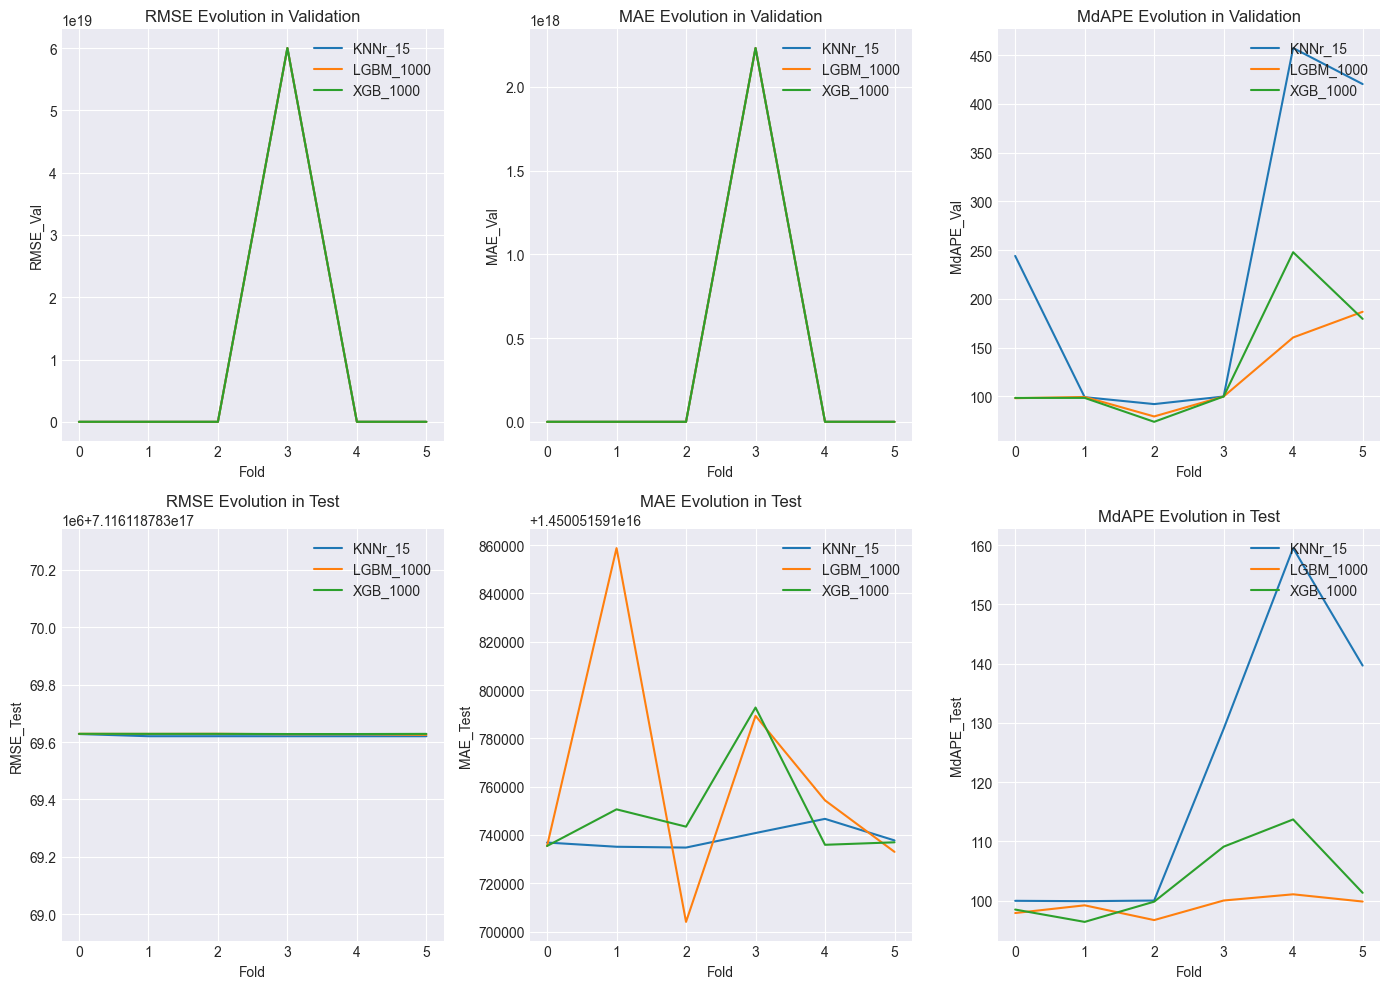

In [127]:
def walkForwardValidation(X, y, X_test, y_test, models, models_names, params, plot=False, fixed_train=False):
    n_splits = params['validation']['n_splits']
    results = pd.DataFrame(columns=["Model", "RMSE_Test", "RMSE_Val", "MAE_Test", "MAE_Val", "MdAPE_Test", "MdAPE_Val", "Mean_MRSE_Test", "Mean_MAE_Test", "Mean_MdAPE_Test","Mean_RMSE_Val", "Mean_MAE_Val", "Mean_MdAPE_Val"])
    y_test = np.expm1(y_test)
    X_sarimax = X[col_names].to_numpy()
    X_test_sarimax = X_test[col_names].to_numpy()
    X, y = X.to_numpy(), y.to_numpy()

    for model, model_name in tqdm(zip(models, models_names), total=len(models)):
        if fixed_train:
            tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size=X.shape[0] // n_splits)
        else:
            tscv = TimeSeriesSplit(n_splits=n_splits)
            
        rmse_test, rmse_val, mae_test, mae_val, mdape_test, mdape_val = [], [], [], [], [], []
        for train_index, eval_index in tscv.split(X):
            X_train, X_val = X[train_index], X[eval_index]
            y_train, y_val = y[train_index], y[eval_index]
            y_val = np.expm1(y_val)

            if "LSTM" in model_name or "GRU" in model_name:
                train_model(model, X_train, y_train, parameters)
                y_pred_val = model.predict(
                    x = X_val,
                    batch_size = parameters["lstm"]["batch_size"]
                ).flatten()
            elif "SARIMAX" in model_name:
                X_sarimax_train, X_sarimax_val = X_sarimax[train_index], X_sarimax[eval_index]
                SARIMAX_model = SARIMAX(y_train, exog=X_sarimax_train, order=(2, 0, 1), seasonal_order=(2, 0, 1, 24))
                model_fit = SARIMAX_model.fit(disp=False)
                forecast = model_fit.get_forecast(steps=len(X_sarimax_val), exog=X_sarimax_val)
                y_pred_val = forecast.predicted_mean 
            else:
                model.fit(X_train, y_train)
                y_pred_val = model.predict(X_val)

            y_pred_val = np.expm1(y_pred_val)
            mae_val.append(mean_absolute_error(y_val, y_pred_val))
            rmse_val.append(root_mean_squared_error(y_val, y_pred_val))
            mdape_val.append(median_absolute_percentage_error(y_val, y_pred_val))

            #Test Scores
            if "LSTM" in model_name or "GRU" in model_name:
                y_pred_test = model.predict(
                    x = X_test,
                    batch_size = parameters["lstm"]["batch_size"]
                ).flatten()

            elif "SARIMAX" in model_name:
                SARIMAX_model = SARIMAX(y_train, exog=X_sarimax_train, order=(2, 0, 1), seasonal_order=(2, 0, 1, 24))
                model_fit = SARIMAX_model.fit(disp=False)
                forecast = model_fit.get_forecast(steps=len(X_test_sarimax), exog=X_test_sarimax)
                y_pred_test = forecast.predicted_mean 
            else:
                y_pred_test = model.predict(X_test)

            #Calculate Metrics
            y_pred_test = np.expm1(y_pred_test)
            mae_test.append(mean_absolute_error(y_test, y_pred_test))
            rmse_test.append(root_mean_squared_error(y_test, y_pred_test))
            mdape_test.append(median_absolute_percentage_error(y_test, y_pred_test))

            
        print(f"Model: {model_name} ===> Mean Test MAE: {np.mean(mae_test)}, RMSE: {np.mean(rmse_test)}, MdAPE: {np.mean(mdape_test)}")
        results.loc[len(results.index)] = [model_name, rmse_test, rmse_val, mae_test, mae_val, mdape_test, mdape_val, np.mean(rmse_test), np.mean(mae_test), np.mean(mdape_test), np.mean(rmse_val), np.mean(mae_val), np.mean(mdape_val)] 
    #Plots
    if plot:
        titles = ["RMSE Evolution in Validation", "MAE Evolution in Validation", "MdAPE Evolution in Validation", "RMSE Evolution in Test", "MAE Evolution in Test", "MdAPE Evolution in Test"]
        metric_names = ["RMSE_Val", "MAE_Val", "MdAPE_Val", "RMSE_Test", "MAE_Test", "MdAPE_Test"]
        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 10))
        for i in range(6):
            metric_name = metric_names[i]
            title = titles[i]
            row = i // 3
            col = i % 3
            ax = axes[row, col]
            for _, row in results.iterrows():
                model_name = row["Model"]
                metric_values = row[metric_name]
                ax.plot(metric_values, label=model_name)

            ax.set_title(title)
            ax.set_xlabel("Fold")
            ax.set_ylabel(metric_name)
            ax.legend(loc='upper right')
            ax.grid(True)
        if fixed_train:
            plt.savefig('../results/Sliding_Window_Validation_plot.png', bbox_inches='tight', dpi=300)
        else:
            plt.savefig('../results/Walking_Forward_Validation_plot.png', bbox_inches='tight', dpi=300)
        plt.tight_layout()
        plt.show()
    return results

results = walkForwardValidation(X_train, y_train, X_test, y_test, models, models_names, parameters, plot=True, fixed_train=False)

### Sliding Window Validation

<div align="center">
    <img src="https://i.sstatic.net/QNlQl.png" width=600px>
</div>

 33%|███▎      | 1/3 [00:00<00:00,  3.70it/s]

Model: KNNr_15 ===> Mean Test MAE: 2.177769551326772, RMSE: 3.969417143638525, MdAPE: 44.397869733852154


 67%|██████▋   | 2/3 [00:07<00:04,  4.44s/it]

Model: LGBM_1000 ===> Mean Test MAE: 1.8192574169418216, RMSE: 3.669657240328947, MdAPE: 34.542477640051864


100%|██████████| 3/3 [00:13<00:00,  4.34s/it]

Model: XGB_1000 ===> Mean Test MAE: 1.731854470281941, RMSE: 3.5126705951755177, MdAPE: 31.797001418613245


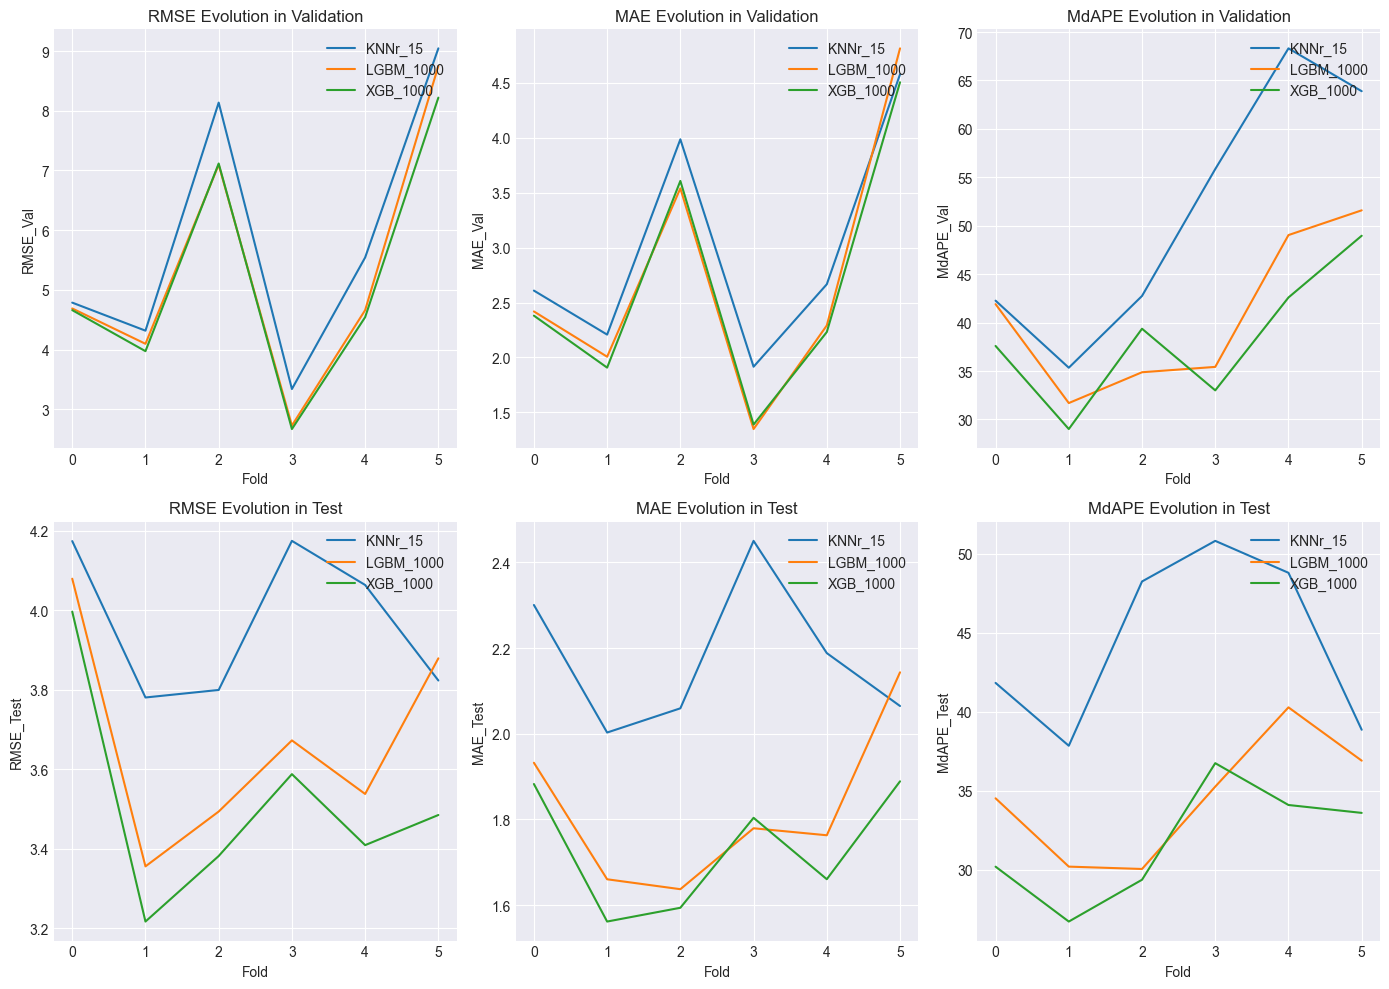

In [100]:
results = walkForwardValidation(X_train, y_train, X_test, y_test, models, models_names, parameters, plot=True, fixed_train=True)

### Grid Search (XGBOOST)

In [101]:
paramsXGB = {
    'max_depth': [7, 8, 9],
    'learning_rate': [0.01, 0.005, 0.003],
    'gamma': [7, 8, 9],
    'colsample_bytree' : [0.7, 0.9, 1],
    'colsample_bynode': [ 0.7, 0.9, 1],
    'n_estimators': [1300]
}

def gridSearchXGB(params):
    best_mae = float('inf')
    config = {}
    for param in tqdm(ParameterGrid(params), total=len(list(ParameterGrid(params)))):
        max_depth = param.get('max_depth')
        n_estimators = param.get('n_estimators')
        lr = param.get('learning_rate')
        gamma = param.get('gamma')
        colsample_bytree = param.get('colsample_bytree')
        colsample_bynode = param.get('colsample_bynode')
        regressorXGBR = XGBRegressor(objective='reg:absoluteerror', n_estimators=n_estimators, learning_rate = lr, max_depth=max_depth, colsample_bytree = colsample_bytree, colsample_bynode = colsample_bynode, gamma=gamma, random_state=123)

        regressorXGBR.fit(
            X = X_train,
            y = y_train,
            verbose=0
        )  
        y_pred = regressorXGBR.predict(X_test)
        
        mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
        if mae < best_mae: 
            best_mae = mae
            config = param
        print(f"MAE: {mae}, n_Estimators: {n_estimators}, Learning_rate: {lr}, Max_depth: {max_depth}, Gamma: {gamma}, Col_Sample_By_Tree: {colsample_bytree}, Col_Sample_By_Node: {colsample_bynode}")
    config["mae"] = best_mae
    return config

#gridSearchXGB(paramsXGB)

### Grid Search (LightGBM)

In [102]:
params = {
    'num_leaves': [10, 20, 30, 40],
    'learning_rate': [0.05, 0.01, 0.005],
    'colsample_bytree' : [0.7, 0.9, 1],
    'n_estimators': [1200],
    'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100]
}

def gridSearchLGBM(params):
    best_mae = float('inf')
    config = {}
    for param in tqdm(ParameterGrid(params), total=len(list(ParameterGrid(params)))):
        n_estimators = param.get('n_estimators')
        num_leaves = param.get('num_leaves')
        lr = param.get('learning_rate')
        reg_alpha = param.get('reg_alpha')
        colsample_bytree = param.get('colsample_bytree')
        LGBMReg = LGBMRegressor(boosting_type='gbdt', n_estimators=n_estimators, learning_rate=lr, random_state=123, reg_alpha=reg_alpha, n_jobs=-1, verbose=-1, num_leaves=num_leaves) 
        LGBMReg.fit(
            X = X_train,
            y = y_train,
        ) 
        y_pred = LGBMReg.predict(X_test)
        mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
        if mae < best_mae: 
            best_mae = mae
            config = param
        print(f"MAE: {mae}, n_Estimators: {n_estimators}, Learning_rate: {lr}, Num_leaves: {num_leaves}, Col_Sample_By_Tree: {colsample_bytree}, reg_alpha: {reg_alpha}")
    config["mae"] = best_mae
    return config
#gridSearchLGBM(params)

### Feature Importance 

In [103]:
regressorXGBR = XGBRegressor(objective='reg:absoluteerror', n_estimators=1300, learning_rate = 0.01, max_depth=9, colsample_bytree = .9, colsample_bynode = 1, gamma=7, random_state=123)
regressorXGBR.fit(
    X = X_train,
    y = y_train,
    verbose=0
)
y_pred = regressorXGBR.predict(X_test)

mae, rmse, mdape, maape = calculate_metrics(np.expm1(y_test), np.expm1(y_pred))
print(f"MAE: {mae}, RMSE: {rmse}, MdAPE: {mdape}, MAAPE: {maape}")

imp_df = pd.DataFrame(data=regressorXGBR.feature_importances_, index=col_names, columns=['importance'])
imp_df.sort_values(by=["importance"])

MAE: 1.326616254465563, RMSE: 3.05991566445401, MdAPE: 27.02990472316741, MAAPE: 45.82584881492458


importance
diffuse_radiation_W/m2           0.026346
lag_5                            0.026863
temperature_2m_C                 0.028244
lag_3                            0.030348
lag_4                            0.030517
shortwave_radiation_W/m2         0.031090
Month_cos                        0.032342
lag_14                           0.038168
isWeekend                        0.039932
lag_2                            0.042033
lag_6                            0.042659
isHoliday                        0.044430
DayOfWeek_sin                    0.044788
Hour_sin                         0.050773
direct_normal_irradiance_W/m2    0.051031
Hour                             0.056617
Hour_cos                         0.078790
lag_7                            0.128682
lag_1                            0.176346

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 41.93it/s]


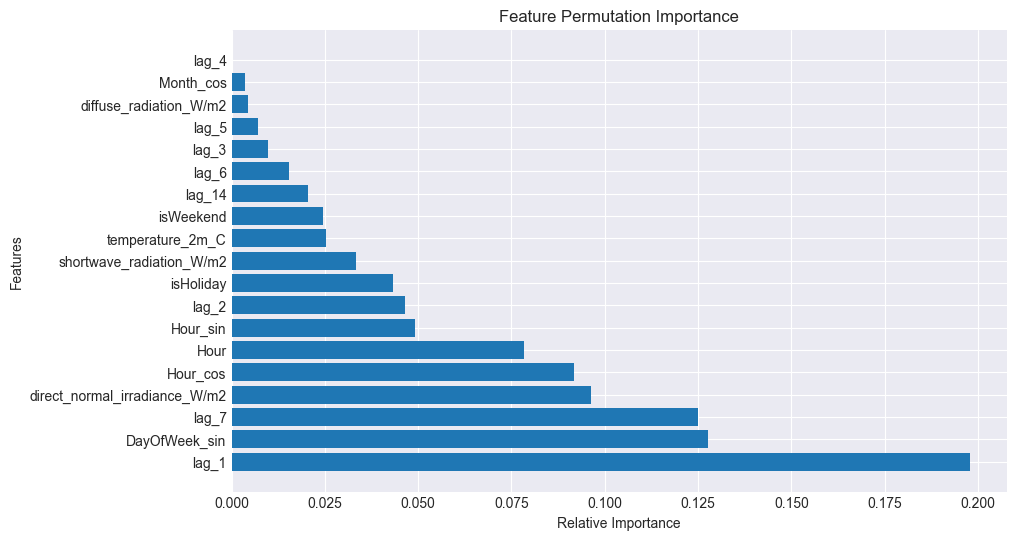

In [104]:
permutation_feature_importance(regressorXGBR, X_test.to_numpy(), y_test, np.array(col_names))

### Plot Prediction Results

In [105]:
plotPredictions(X_test_dates, np.expm1(y_pred), np.expm1(y_test), "predictions_Test_All")

In [106]:
plotPredictions(X_test_dates[:30*24], np.expm1(y_pred[:30*24]), np.expm1(y_test[:30*24]), "predictions_Test_Month")

In [107]:
plotPredictions(X_test_dates[:24*7], np.expm1(y_pred[:24*7]), np.expm1(y_test[:24*7]), "predictions_Test_Week")

In [108]:
print(f"Test Demand Min: {np.min(np.expm1(y_test))} - Max: {np.max(np.expm1(y_test))}")
print(f"Predicted Demand Min: {np.min(np.expm1(y_pred))} - Max: {np.max(np.expm1(y_pred))}")

Test Demand Min: 0.0 - Max: 45.0
Predicted Demand Min: -0.0778898298740387 - Max: 19.43025016784668
